<a href="https://colab.research.google.com/github/kutouxiyiji/other/blob/master/Quora_alpha_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

'Over 100 million people visit Quora every month, so it's no surprise that many people ask similarly worded questions. Multiple questions with the same intent can cause seekers to spend more time finding the best answer to their question, and make writers feel they need to answer multiple versions of the same question. Quora values canonical questions because they provide a better experience to active seekers and writers, and offer more value to both of these groups in the long term.'



---

The purpose of this project is too identy the duplicate questions. This notebook will expore the data features and do some basic ML exploration. 
At first, we mount the google drive and load the data. 

In [0]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import train_test_split
import numpy as np
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import pickle

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import sys
sys.path.append('/content/drive/My Drive/Python/dataSet/Quora/')

In [0]:
from zipfile import ZipFile 
file_name = '/content/drive/My Drive/Python/dataSet/Quora/train.csv.zip'
ZipFile(file_name, 'r').extractall() 

In [0]:
df_train_original = pd.read_csv('/content/train.csv')
df_train_original.head()
df_train_original.to_csv('/content/drive/My Drive/Python/dataSet/Quora/train_df.csv', index=False) 

In [0]:
df_train_original.head() 

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


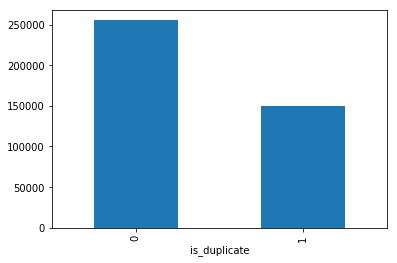

In [0]:
df_train_original.groupby('is_duplicate')['id'].count().plot.bar()


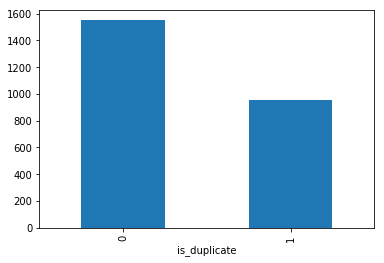

In [0]:
df_train_part1 = df_train_original[:2500]
df_train_part1.groupby('is_duplicate')['id'].count().plot.bar()

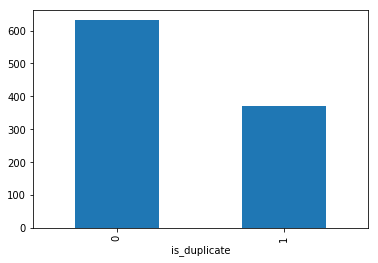

In [0]:
df_testDummy = df_train_original[2500:3500]
df_testDummy.groupby('is_duplicate')['id'].count().plot.bar()

In [0]:
#df_readyforvec = df_train_part1[['question1','question2']]
#np_readyforvec = df_readyforvec.as_matrix
#np_readyforvec
#df_train_part1['question1'].as_matrix
#df_train_part1['question2'].as_matrix


In [0]:
train_part1_qs = pd.Series(df_train_part1['question1'].as_matrix() + df_train_part1['question2'].as_matrix() ).astype(str)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.


(-0.5, 1439.5, 1079.5, -0.5)

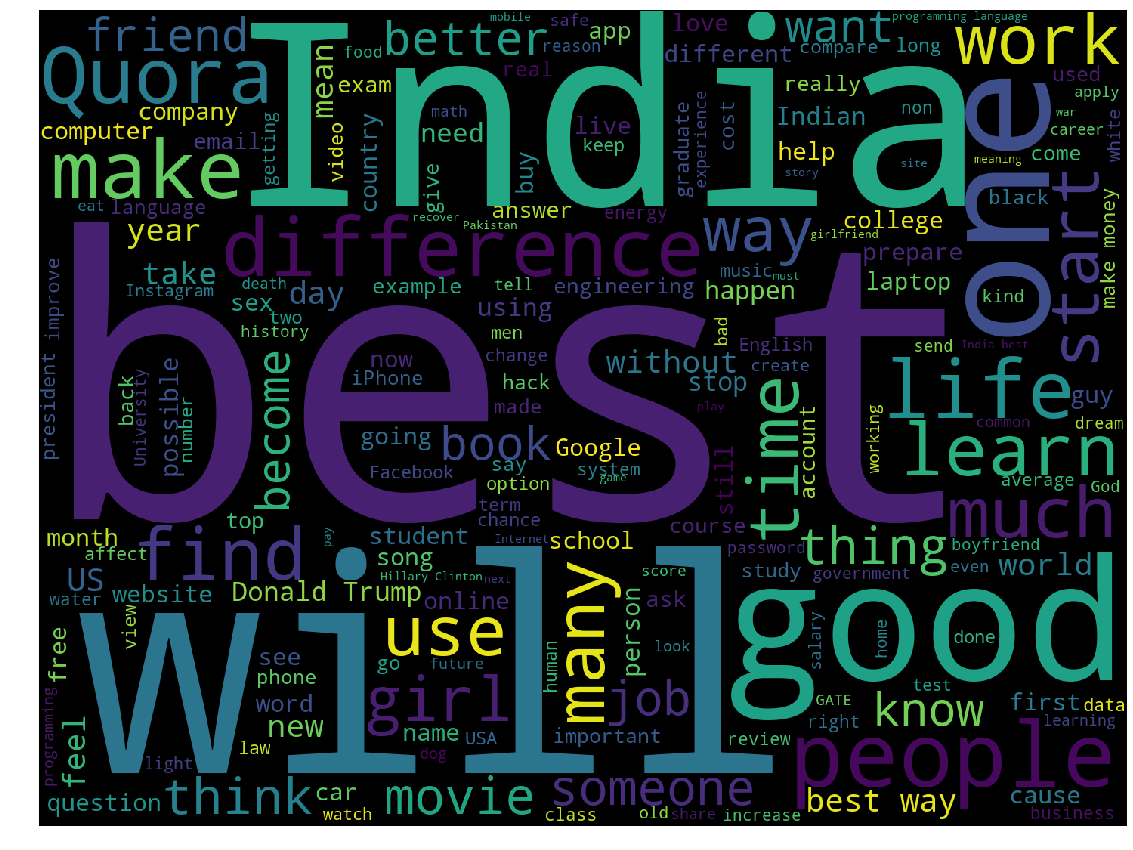

In [0]:
cloud = WordCloud(width=1440, height=1080).generate(" ".join(train_part1_qs.astype(str)))
plt.figure(figsize=(20, 15))
plt.imshow(cloud)
plt.axis('off')

In [0]:
tvec = TfidfVectorizer()
#tvec.fit(np_readyforvec)
X_part1 = tvec.fit_transform(train_part1_qs)#(df_train_part1[['question1','question2']])
#X_train_part1 = X_train_part1.as_matrix
y_part1 = df_train_part1['is_duplicate']
y_part1.shape, X_train_part1.shape

((2500,), (2500, 5323))

In [0]:
X_part1_train, X_part1_test, y_part1_train, y_part1_test = train_test_split(X_part1, y_part1, test_size=0.25, random_state=42)

In [0]:
model = LogisticRegressionCV()
model.fit(X_part1_train,y_part1_train)

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


LogisticRegressionCV(Cs=10, class_weight=None, cv='warn', dual=False,
                     fit_intercept=True, intercept_scaling=1.0, l1_ratios=None,
                     max_iter=100, multi_class='warn', n_jobs=None,
                     penalty='l2', random_state=None, refit=True, scoring=None,
                     solver='lbfgs', tol=0.0001, verbose=0)

In [0]:
model.score(X_part1_test,y_part1_test)

0.72

In [0]:
rdf = RandomForestClassifier(n_estimators=200, max_depth=2,random_state=0)

In [0]:
rdf.fit(X_part1_train,y_part1_train)
rdf.score(X_part1_test,y_part1_test)

0.6416

In [0]:
params = {}
params['objective'] = 'binary:logistic'
params['eval_metric'] = 'logloss'
params['eta'] = 0.02
params['max_depth'] = 4

d_train = xgb.DMatrix(X_part1_test, label=y_part1_train)
bst = xgb.train(params, d_train)

array(['What is the step by step guide to invest in share market in india?',
       'What is the story of Kohinoor (Koh-i-Noor) Diamond?',
       'How can I increase the speed of my internet connection while using a VPN?',
       ..., 'What is one coin?',
       'What is the approx annual cost of living while studying in UIC Chicago, for an Indian student?',
       'What is like to have sex with cousin?'], dtype=object)

In [0]:
# train on the whole data set
train_qs = pd.Series(df_train_original['question1'].astype('str').values + df_train_original['question2'].astype('str').values)
train_qs[0]

'What is the step by step guide to invest in share market in india?What is the step by step guide to invest in share market?'

In [0]:
X = tvec.fit_transform(train_qs)#(df_train_part1[['question1','question2']])
y = df_train_original['is_duplicate']
y.shape, X.shape

((404290,), (404290, 87011))

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [0]:
model = LogisticRegressionCV()
model.fit(X_train,y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.

LogisticRegressionCV(Cs=10, class_weight=None, cv='warn', dual=False,
                     fit_intercept=True, intercept_scaling=1.0, l1_ratios=None,
                     max_iter=100, multi_class='warn', n_jobs=None,
                     penalty='l2', random_state=None, refit=True, scoring=None,
                     solver='lbfgs', tol=0.0001, verbose=0)

In [0]:
model.score(X_test,y_test)


0.7591443305150807

In [0]:
filename = '/content/drive/My Drive/Python/dataSet/Quora/logisticCV_1.model'
pickle.dump(model, open(filename, 'wb'))

In [0]:
rdf = RandomForestClassifier(n_estimators=200, max_depth=3,random_state=0)
rdf.fit(X_train,y_train)
rdf.score(X_test,y_test)

0.629422258199916

In [0]:
filename = '/content/drive/My Drive/Python/dataSet/Quora/RandomForest_1.model'
pickle.dump(model, open(filename, 'wb'))

In [0]:
# simple improve
tvec2 = TfidfVectorizer(max_features = 256)
tvec2.fit(df_train_original['question1'].astype('str').values)
X1 = tvec2.transform(df_train_original['question1'].astype('str').values)
X2 = tvec2.transform(df_train_original['question2'].astype('str').values)


In [0]:
X1.shape, X2.shape

((404290, 256), (404290, 256))

In [0]:
X =  np.concatenate((X1,X2),axis = 1)

ValueError: ignored

In [0]:
X1.shape, X2.shape

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

ValueError: ignored

In [0]:
X.shape, X1.shape

((404290, 256), (404290, 256))

In [0]:
rdf = RandomForestClassifier(n_estimators=200, max_depth=3,random_state=0)
rdf.fit(X_train,y_train)
rdf.score(X_test,y_test)

0.6314310127720814

In [0]:
model = LogisticRegressionCV()
model.fit(X_train,y_train)
model.score(X_test,y_test)


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


0.629422258199916